# 1. Import the required libraries

In [1]:
# Standard code libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Custom code libraries from ReSurfEMG
from resurfemg.data_connector.config import Config
from resurfemg.data_connector import file_discovery
from resurfemg.preprocessing import filtering as filt
from resurfemg.postprocessing import features as feat
from resurfemg.preprocessing import ecg_removal as ecg_rm
from resurfemg.postprocessing import quality_assessment as qa
from resurfemg.pipelines import ipy_widgets
from resurfemg.data_connector.tmsisdk_lite import Poly5Reader
from resurfemg.data_connector.data_classes import (
VentilatorDataGroup, EmgDataGroup)

%matplotlib widget

## 2. Load the sEMG data

In [2]:
config = Config()

base_path = config.get_directory('zwolle_data')
folder_levels = None

emg_files = file_discovery.find_files(
    base_path=base_path,
    extension_regex='poly5',
    folder_levels=None)

In [3]:
# If you want to select another file:
btn_list_emg = ipy_widgets.file_select(
    emg_files,
    folder_levels=['files'],
    default_value_select=None,
    default_idx_select=[0])

interactive(children=(Dropdown(description='files:', options=('0001\\20230327T113742\\20230327_113742.Data14Ch…

### 1 cell to run from here!

In [24]:
emg_file_chosen = os.path.join(base_path, *[btn.value for btn in btn_list_emg])
data_emg = Poly5Reader(emg_file_chosen)
data_emg_samples = data_emg.samples[:data_emg.num_samples]
fs_emg = data_emg.sample_rate
n_ch = 4
# Define the time series of the EMG recording
y_emg = data_emg_samples[:n_ch,:]

# Define the time axes
t_emg = [i/fs_emg for i in range(len(y_emg[0, :]))]

# Store the EMG data in a group of TimeSeries objects
emg_timeseries = EmgDataGroup(
    y_emg,
    fs=fs_emg,
    labels=['Intercost','Dia R','Dia L', 'Abd'],
    units=n_ch*['uV'])

# Filter
emg_timeseries.run('filter_emg', lp_cf=200)

# set ecg channel to channel 0
emg_timeseries.set_ecg_idx(0)
# apply gating according to QRS peaks in ECG channel
emg_timeseries.run('gating',
   gate_width_samples=fs_emg//4, overwrite=True)

emg_timeseries.run('envelope',env_window=100)

emg_timeseries.run('baseline')

# Find sEAdi peaks
intercost = emg_timeseries.channels[0]
intercost.detect_emg_breaths(peak_set_name='breaths')
intercost.peaks['breaths'].detect_on_offset(
    baseline=intercost.y_baseline)

emg_di_r = emg_timeseries.channels[1]
emg_di_r.detect_emg_breaths(peak_set_name='breaths')
emg_di_r.peaks['breaths'].detect_on_offset(
    baseline=emg_di_r.y_baseline
)
emg_di_l = emg_timeseries.channels[2]
emg_di_l.detect_emg_breaths(peak_set_name='breaths')
emg_di_l.peaks['breaths'].detect_on_offset(
    baseline=emg_di_l.y_baseline
)

# Get the indices of all detected breaths
breath_peak_idxs_di_r = emg_di_r.peaks['breaths'].peak_df['peak_idx'].to_numpy()
breath_peak_idxs_di_l = emg_di_l.peaks['breaths'].peak_df['peak_idx'].to_numpy()
breath_peak_idxs_intercost = intercost.peaks['breaths'].peak_df['peak_idx'].to_numpy()

# Calculate the amplitude of all detected breaths
sEAdi_amplitudes_dia_r = feat.amplitude(
    signal=emg_di_r.y_env,
    peak_idxs=breath_peak_idxs_di_r,
    baseline=emg_di_r.y_baseline,
)

# Calculate the area under the curve (AUC) for all detected breaths
emg_di_r.calculate_time_products(
    peak_set_name='breaths', parameter_name='AUC')
emg_di_l.calculate_time_products(
    peak_set_name='breaths', parameter_name='AUC')
intercost.calculate_time_products(
    peak_set_name='breaths', parameter_name='AUC')

# Test EMG quality
parameter_names = {
    'time_product': 'AUC'
}
emg_di_r.test_emg_quality(
    peak_set_name='breaths', parameter_names=parameter_names, verbose=False)
emg_di_l.test_emg_quality(
    peak_set_name='breaths', parameter_names=parameter_names, verbose=False)
intercost.test_emg_quality(
    peak_set_name='breaths', parameter_names=parameter_names, verbose=False)

file_name = os.path.basename(emg_file_chosen).replace('.Data8Raw.Poly5', '')
patient_number = os.path.basename(os.path.dirname(os.path.dirname(emg_file_chosen)))
csv_filename = f"{patient_number}_{file_name}.csv"
muscle = 'dia_r'
csv_path = os.path.join(base_path, csv_filename, muscle)
dia_r = emg_timeseries[0].peaks['breaths'].peak_df
dia_r.to_csv(csv_path, index=False)
muscle = 'dia_l'
csv_path = os.path.join(base_path, csv_filename, muscle)
dia_l = emg_timeseries[1].peaks['breaths'].peak_df
dia_l.to_csv(csv_path, index=False)
muscle = 'intercost'
csv_path = os.path.join(base_path, csv_filename, muscle)
intercost = emg_timeseries[2].peaks['breaths'].peak_df
intercost.to_csv(csv_path, index=False)

# # Filter the DataFrame to include only valid peaks
# valid_peaks_df_di_r = emg_di_r.peaks['breaths'].peak_df[emg_di_r.peaks['breaths'].peak_df['valid'] == True]
# valid_peaks_df_di_l = emg_di_l.peaks['breaths'].peak_df[emg_di_l.peaks['breaths'].peak_df['valid'] == True]
# valid_peaks_df_intercost = intercost.peaks['breaths'].peak_df[intercost.peaks['breaths'].peak_df['valid'] == True]

# # data
# total_detected_peaks_di_r = len(emg_di_r.peaks['breaths'].peak_df)
# total_detected_peaks_di_l = len(emg_di_l.peaks['breaths'].peak_df)
# total_detected_peaks_intercost = len(intercost.peaks['breaths'].peak_df)

# num_valid_breaths_di_r = len(valid_peaks_df_di_r)
# num_valid_breaths_di_l = len(valid_peaks_df_di_l)
# num_valid_breaths_intercost = len(valid_peaks_df_intercost)

# mean_auc_di_r = valid_peaks_df_di_r['AUC'].mean()
# mean_auc_di_l = valid_peaks_df_di_l['AUC'].mean()
# mean_auc_intercost = valid_peaks_df_intercost['AUC'].mean()

# median_auc_di_r = valid_peaks_df_di_r['AUC'].median()
# median_auc_di_l = valid_peaks_df_di_l['AUC'].median()
# median_auc_intercost = valid_peaks_df_intercost['AUC'].median()

# std_auc_di_r = valid_peaks_df_di_r['AUC'].std()
# std_auc_di_l = valid_peaks_df_di_l['AUC'].std()
# std_auc_intercost = valid_peaks_df_intercost['AUC'].std()


# excel_path = 'P:/TNW/CRPH/Projects/2025_Mos_Isala/data.xlsx'
# file_name = os.path.basename(emg_file_chosen).replace('.Data8Raw.Poly5', '')
# patient_number = os.path.basename(os.path.dirname(os.path.dirname(emg_file_chosen)))
# results = [
#     patient_number,
#     file_name,
#     total_detected_peaks_di_r,
#     num_valid_breaths_di_r,
#     mean_auc_di_r,
#     median_auc_di_r,
#     std_auc_di_r,
#     total_detected_peaks_di_l,
#     num_valid_breaths_di_l,
#     mean_auc_di_l,
#     median_auc_di_l,
#     std_auc_di_l,
#     total_detected_peaks_intercost,
#     num_valid_breaths_intercost,
#     mean_auc_intercost,
#     median_auc_intercost,
#     std_auc_intercost
# ]

# try:
#     df = pd.read_excel(excel_path, header=None, engine='openpyxl')
# except FileNotFoundError:
#     df = pd.DataFrame()

# first_empty_row = len(df)
# for i, value in enumerate(results):
#     df.at[first_empty_row, i] = value

# df.to_excel(excel_path, index=False, header=False)

Reading file  P:\TNW\CRPH\Projects\2025_Mos_Isala\0005\20230525T112010\20230525_112011.Data8Raw.Poly5
	 Number of samples:  173745 
	 Number of channels:  21 
	 Sample rate: 500 Hz
Done reading data.
No ECG channel detected. Set ECG channel index with `EmgDataGroup.set_ecg_idx(arg)` method.
Set ECG channel used for ECG removal.


OSError: Cannot save file into a non-existent directory: 'P:\TNW\CRPH\Projects\2025_Mos_Isala\0005_20230525_112011.csv'

In [4]:
# Load the EMG  data recordings from the selected folders. RAW files
emg_file_chosen = os.path.join(base_path, *[btn.value for btn in btn_list_emg])
data_emg = Poly5Reader(emg_file_chosen)
data_emg_samples = data_emg.samples[:data_emg.num_samples]
fs_emg = data_emg.sample_rate
n_ch = 4
# Define the time series of the EMG recording
y_emg = data_emg_samples[:n_ch,:]

# Define the time axes
t_emg = [i/fs_emg for i in range(len(y_emg[0, :]))]

Reading file  P:\TNW\CRPH\Projects\2025_Mos_Isala\0005\20230525T112010\20230525_112011.Data8Raw.Poly5
	 Number of samples:  173745 
	 Number of channels:  21 
	 Sample rate: 500 Hz
Done reading data.


In [5]:
# Store the EMG data in a group of TimeSeries objects
emg_timeseries = EmgDataGroup(
    y_emg,
    fs=fs_emg,
    labels=['Intercost','Dia R','Dia L', 'Abd'],
    units=n_ch*['uV'])

No ECG channel detected. Set ECG channel index with `EmgDataGroup.set_ecg_idx(arg)` method.


# 3. Pre-process the data

In [6]:
# Filter
emg_timeseries.run('filter_emg', lp_cf=200)

In [7]:
# set ecg channel to channel 0
emg_timeseries.set_ecg_idx(0)
# apply gating according to QRS peaks in ECG channel
emg_timeseries.run('gating',
   gate_width_samples=fs_emg//4, overwrite=True)

Set ECG channel used for ECG removal.


In [8]:
emg_timeseries.run('envelope',env_window=100)

In [9]:
emg_timeseries.run('baseline')

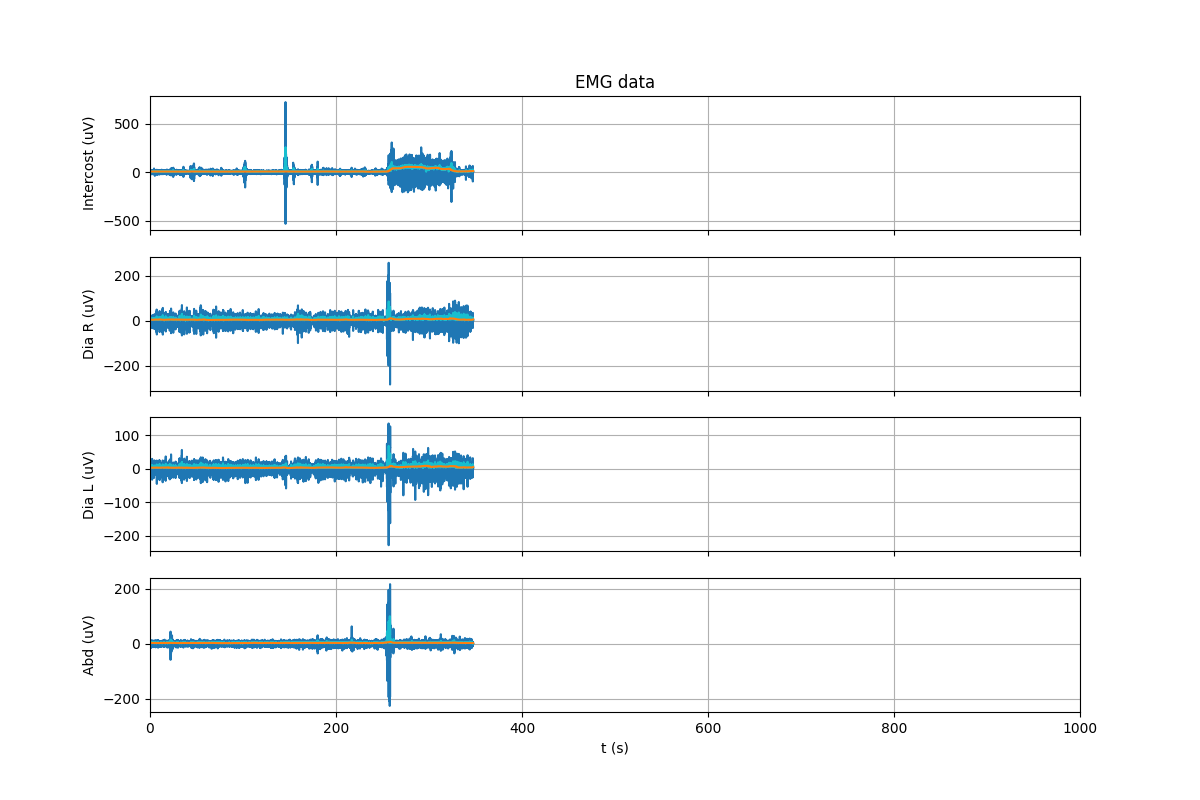

In [10]:
# Plot the raw data with the envelope
n_ch=4
fig, axis = plt.subplots(nrows=n_ch, ncols=1, figsize=(12, n_ch/3*6), sharex=True)
axes_emg = axis[:n_ch]
colors = ['tab:cyan', 'tab:orange']
emg_timeseries.run('plot_full',
    axes=axes_emg, signal_type='clean', baseline_bool=False)

emg_timeseries.run('plot_full',axes=axes_emg, signal_type='env', colors=colors)

axes_emg[0].set_title('EMG data')
axes_emg[-1].set_xlabel('t (s)')
for ax in axes_emg:
    #ax.set_ylim(-100, 100)
    ax.set_xlim(0,1000)

# 3. Identify all sEMG breaths

In [11]:
# Find sEAdi peaks
intercost = emg_timeseries.channels[0]
intercost.detect_emg_breaths(peak_set_name='breaths')
intercost.peaks['breaths'].detect_on_offset(
    baseline=intercost.y_baseline)

emg_di_r = emg_timeseries.channels[1]
emg_di_r.detect_emg_breaths(peak_set_name='breaths')
emg_di_r.peaks['breaths'].detect_on_offset(
    baseline=emg_di_r.y_baseline
)
emg_di_l = emg_timeseries.channels[2]
emg_di_l.detect_emg_breaths(peak_set_name='breaths')
emg_di_l.peaks['breaths'].detect_on_offset(
    baseline=emg_di_l.y_baseline
)

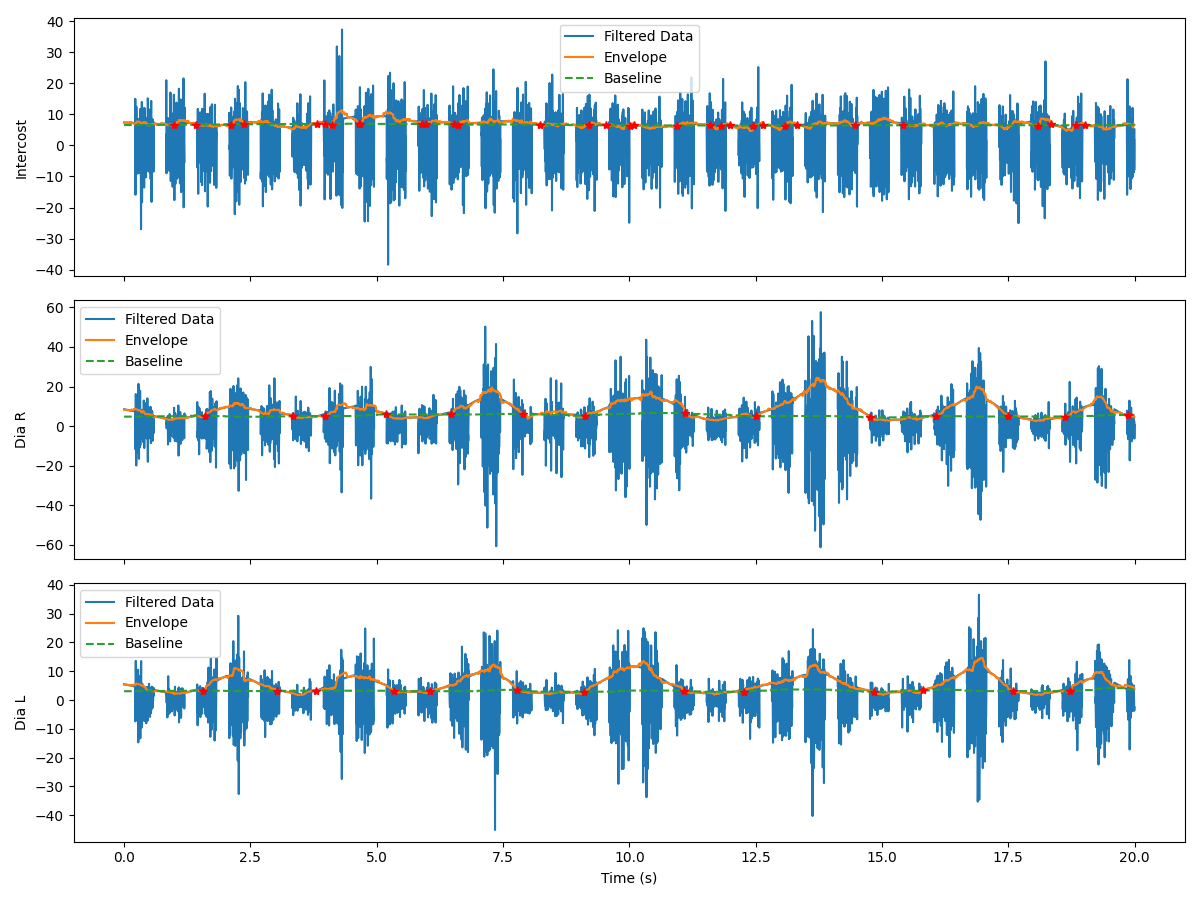

In [12]:
# Define the time range for the first 20 seconds
time_range = 20  # seconds
end_idx = int(time_range * fs_emg)
n_ch=3
# Create a figure with subplots for each channel
fig, axes = plt.subplots(nrows=n_ch, ncols=1, figsize=(12, n_ch * 3), sharex=True)

# Plot each channel
for i in range(n_ch):
    # Extract the segments of the signals
    filtered_segment = emg_timeseries.channels[i].y_clean[:end_idx]
    envelope_segment = emg_timeseries.channels[i].y_env[:end_idx]
    baseline_segment = emg_timeseries.channels[i].y_baseline[:end_idx]
    time_segment = emg_timeseries.channels[i].t_data[:end_idx]

    # Plot the segments
    axes[i].plot(time_segment, filtered_segment, label='Filtered Data', linestyle='-')
    axes[i].plot(time_segment, envelope_segment, label='Envelope', linestyle='-')
    axes[i].plot(time_segment, baseline_segment, label='Baseline', linestyle='--')

    # Plot the markers manually with red asterisks
    for peak in emg_timeseries.channels[i].peaks['breaths'].peak_df.itertuples():
        if peak.start_idx < end_idx:
            axes[i].plot(emg_timeseries.channels[i].t_data[peak.start_idx], emg_timeseries.channels[i].y_env[peak.start_idx], 'r*')  # Start marker
        if peak.end_idx < end_idx:
            axes[i].plot(emg_timeseries.channels[i].t_data[peak.end_idx], emg_timeseries.channels[i].y_env[peak.end_idx], 'r*')      # End marker

    # Add titles and labels
    axes[i].set_ylabel(emg_timeseries.channels[i].label)
    axes[i].legend()

axes[-1].set_xlabel('Time (s)')
plt.tight_layout()
plt.show()

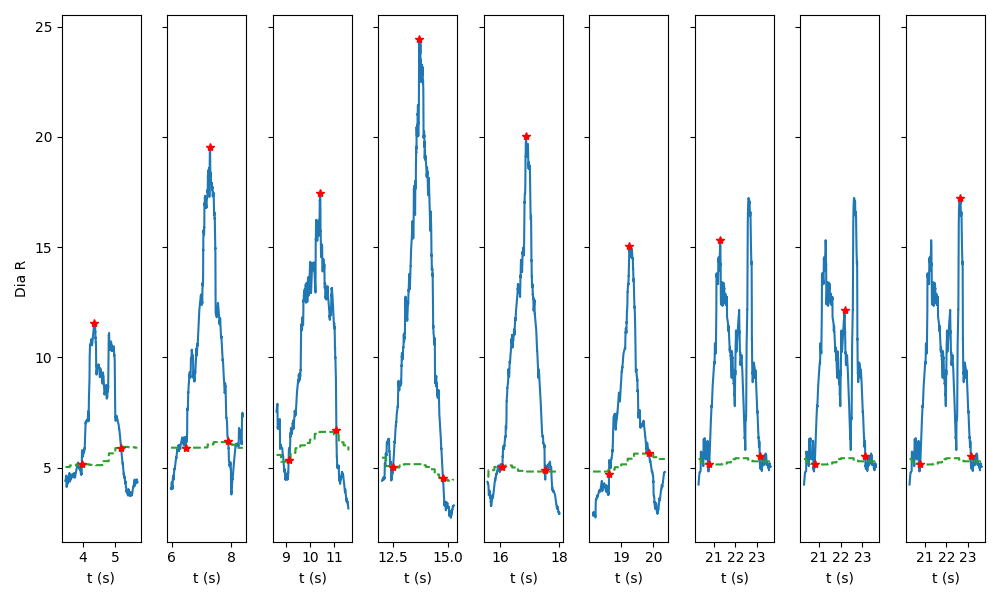

In [13]:
# Select the peaks to plot
peak_df = emg_di_r.peaks['breaths'].peak_df.iloc[1:10]

# Define the number of samples to plot before and after the peak
margin_samples = fs_emg // 2  # Half a second before and after

# Plot the selected peaks for sEAdi
n_peaks = len(peak_df)
fig, axis = plt.subplots(nrows=1, ncols=n_peaks, figsize=(10, 6), sharey='row')

# Ensure axes_emg is always a list of axes
if n_peaks == 1:
    axes_emg = [axis]
else:
    axes_emg = axis[:]

colors = ['tab:cyan', 'tab:orange', 'tab:red']

# Plot each selected peak individually
for i, row in enumerate(peak_df.itertuples()):
    start_idx = max(row.start_idx - margin_samples, 0)
    end_idx = min(row.end_idx + margin_samples, len(emg_di_r.y_env))

    # Extract the segment of the signal corresponding to the peak
    segment = emg_di_r.y_env[start_idx:end_idx]
    time = emg_di_r.t_data[start_idx:end_idx]

    # Plot the segment
    axes_emg[i].plot(time, segment, color='tab:blue')

    # Plot the baseline
    baseline_segment = emg_di_r.y_baseline[start_idx:end_idx]
    axes_emg[i].plot(time, baseline_segment, color='tab:green', linestyle='--')

    # Plot the markers manually with red asterisks
    axes_emg[i].plot(emg_di_r.t_data[row.start_idx], emg_di_r.y_env[row.start_idx], 'r*')  # Start marker
    axes_emg[i].plot(emg_di_r.t_data[row.end_idx], emg_di_r.y_env[row.end_idx], 'r*')      # End marker
    peak_idx = row.peak_idx
    axes_emg[i].plot(emg_di_r.t_data[peak_idx], emg_di_r.y_env[peak_idx], 'r*')           # Peak marker

# Set labels
axes_emg[0].set_ylabel(emg_di_r.label)
for ax in axes_emg:
    ax.set_xlabel('t (s)')

plt.tight_layout()
plt.show()


# 5. Calculate features

In [ ]:
# Respiratory rate

emg_di_idxs_r = emg_di_r.peaks['breaths'].peak_df['peak_idx'].to_numpy()
rr_di_r, _ = feat.respiratory_rate(emg_di_idxs_r, fs_emg)

emg_di_idxs_l = emg_di_l.peaks['breaths'].peak_df['peak_idx'].to_numpy()
rr_di_l, _ = feat.respiratory_rate(emg_di_idxs_l, fs_emg)

emg_di_idxs_int = intercost.peaks['breaths'].peak_df['peak_idx'].to_numpy()
rr_intercost, _ = feat.respiratory_rate(emg_di_idxs_int, fs_emg)

print(rr_di_r)
print(rr_di_l)
print(rr_intercost)

24.59016393442623
25.231286795626577
46.08294930875576


In [15]:
# Get the indices of all detected breaths
breath_peak_idxs_di_r = emg_di_r.peaks['breaths'].peak_df['peak_idx'].to_numpy()
breath_peak_idxs_di_l = emg_di_l.peaks['breaths'].peak_df['peak_idx'].to_numpy()
breath_peak_idxs_intercost = intercost.peaks['breaths'].peak_df['peak_idx'].to_numpy()

# Calculate the amplitude of all detected breaths
sEAdi_amplitudes_dia_r = feat.amplitude(
    signal=emg_di_r.y_env,
    peak_idxs=breath_peak_idxs_di_r,
    baseline=emg_di_r.y_baseline,
)

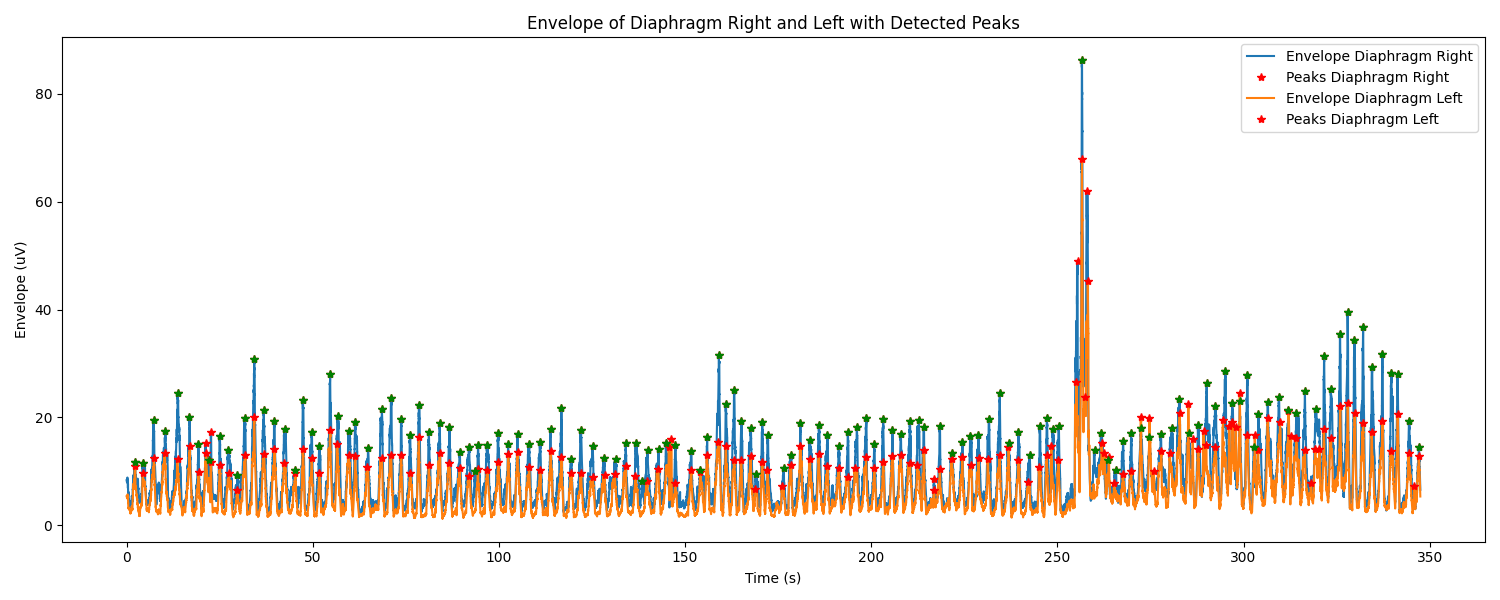

In [16]:
plt.figure(figsize=(15, 6))

# Plot envelope for right diaphragm
plt.plot(emg_di_r.t_data, emg_di_r.y_env, label='Envelope Diaphragm Right', color='tab:blue')
plt.plot(emg_di_r.t_data[emg_di_idxs_r], emg_di_r.y_env[emg_di_idxs_r], 'r*', label='Peaks Diaphragm Right')

# Plot envelope for left diaphragm
plt.plot(emg_di_l.t_data, emg_di_l.y_env, label='Envelope Diaphragm Left', color='tab:orange')
plt.plot(emg_di_l.t_data[emg_di_idxs_l], emg_di_l.y_env[emg_di_idxs_l], 'r*', label='Peaks Diaphragm Left')

plt.xlabel('Time (s)')
plt.ylabel('Envelope (uV)')
plt.title('Envelope of Diaphragm Right and Left with Detected Peaks')
plt.legend()
plt.tight_layout()
# Overlay green asterisks for valid peaks (right diaphragm)
valid_peaks_r = emg_di_r.peaks['breaths'].peak_df[emg_di_r.peaks['breaths'].peak_df['valid'] == True]['peak_idx'].to_numpy()
plt.plot(emg_di_r.t_data[valid_peaks_r], emg_di_r.y_env[valid_peaks_r], 'g*', label='Valid Peaks Diaphragm Right')

plt.show()

In [18]:
# Calculate the area under the curve (AUC) for all detected breaths
emg_di_r.calculate_time_products(
    peak_set_name='breaths', parameter_name='AUC')
emg_di_l.calculate_time_products(
    peak_set_name='breaths', parameter_name='AUC')
intercost.calculate_time_products(
    peak_set_name='breaths', parameter_name='AUC')

# Store the AUC values in a variable
#sEAdi_auc_di_r = emg_di_r.peaks['breaths'].peak_df['AUC'].to_numpy()


# 6. Test sEMG quality

In [19]:
# Test EMG quality
parameter_names = {
    'time_product': 'AUC'
}
emg_di_r.test_emg_quality(
    peak_set_name='breaths', parameter_names=parameter_names, verbose=False)
emg_di_l.test_emg_quality(
    peak_set_name='breaths', parameter_names=parameter_names, verbose=False)
intercost.test_emg_quality(
    peak_set_name='breaths', parameter_names=parameter_names, verbose=False)


C:\Users\OppersmaE\AppData\Local\Temp\ipykernel_34712\417963505.py:41: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


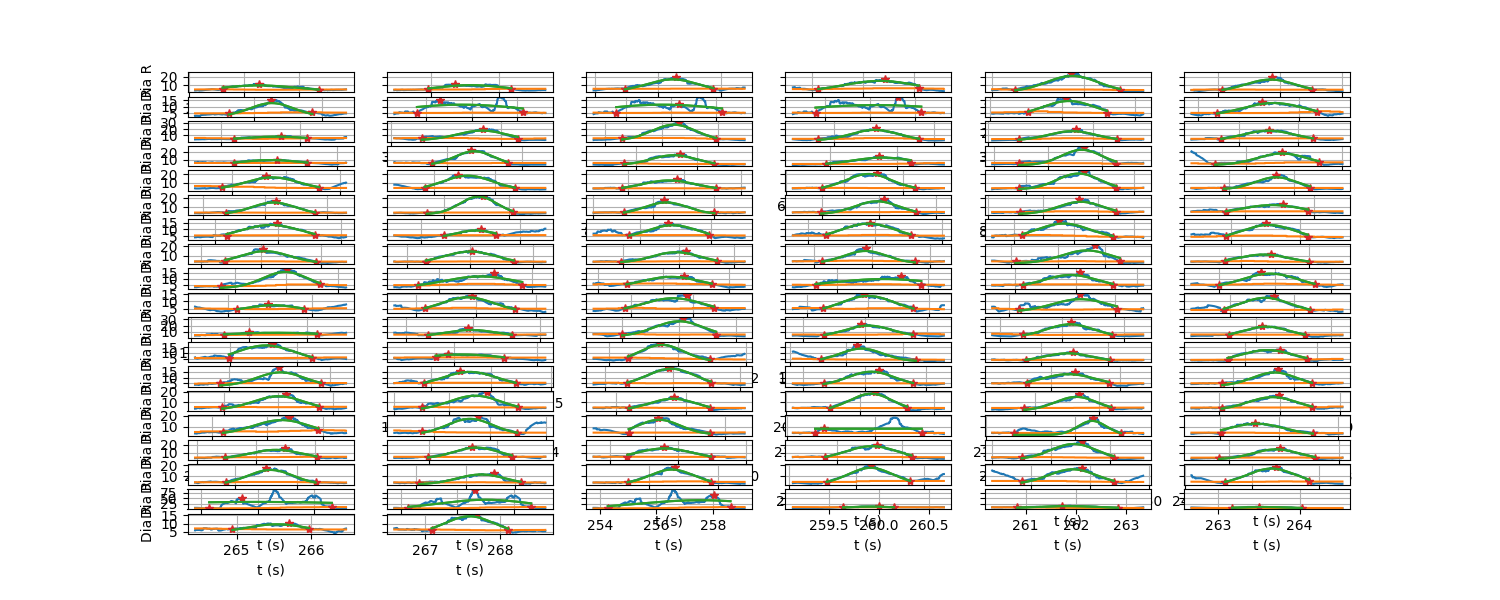

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Filter the DataFrame to include only valid peaks
valid_peaks_df_di_r = emg_di_r.peaks['breaths'].peak_df[emg_di_r.peaks['breaths'].peak_df['valid'] == True]
valid_peaks_df_di_l = emg_di_l.peaks['breaths'].peak_df[emg_di_l.peaks['breaths'].peak_df['valid'] == True]
valid_peaks_df_intercost = intercost.peaks['breaths'].peak_df[intercost.peaks['breaths'].peak_df['valid'] == True]

# Get the number of valid peaks
n_peaks = len(valid_peaks_df_di_r['start_idx'].to_numpy())

# Define the maximum number of columns
max_cols = 6

# Calculate the number of rows needed
n_rows = int(np.ceil(n_peaks / max_cols))

fig, axes = plt.subplots(nrows=n_rows, ncols=max_cols, figsize=(15, 6), sharey='row')

# Flatten the axes array for easy iteration
axes_flat = axes.flatten()

# Ensure axes_emg is always a list of axes
axes_emg = axes_flat[:n_peaks]

colors = ['tab:cyan', 'tab:orange', 'tab:red']
emg_di_r.plot_peaks(axes=axes_emg, peak_set_name='breaths')
emg_di_r.plot_markers(axes=axes_emg, peak_set_name='breaths')
emg_di_r.plot_curve_fits(axes=axes_emg, peak_set_name='breaths')

# Set labels for the first column and all axes
for i, axis in enumerate(axes_emg):
    if i % max_cols == 0:
        axis.set_ylabel(emg_di_r.label)
    axis.set_xlabel('t (s)')

# Hide any unused subplots
for j in range(n_peaks, len(axes_flat)):
    fig.delaxes(axes_flat[j])

plt.tight_layout()
plt.show()


In [21]:
# data
total_detected_peaks_di_r = len(emg_di_r.peaks['breaths'].peak_df)
total_detected_peaks_di_l = len(emg_di_l.peaks['breaths'].peak_df)
total_detected_peaks_intercost = len(intercost.peaks['breaths'].peak_df)

num_valid_breaths_di_r = len(valid_peaks_df_di_r)
num_valid_breaths_di_l = len(valid_peaks_df_di_l)
num_valid_breaths_intercost = len(valid_peaks_df_intercost)

mean_auc_di_r = valid_peaks_df_di_r['AUC'].mean()
mean_auc_di_l = valid_peaks_df_di_l['AUC'].mean()
mean_auc_intercost = valid_peaks_df_intercost['AUC'].mean()

median_auc_di_r = valid_peaks_df_di_r['AUC'].median()
median_auc_di_l = valid_peaks_df_di_l['AUC'].median()
median_auc_intercost = valid_peaks_df_intercost['AUC'].median()

std_auc_di_r = valid_peaks_df_di_r['AUC'].std()
std_auc_di_l = valid_peaks_df_di_l['AUC'].std()
std_auc_intercost = valid_peaks_df_intercost['AUC'].std()


In [23]:
A=emg_timeseries[0].peaks['breaths'].peak_df

In [ ]:
A.to_csv('P:/TNW/CRPH/Projects/2025_Mos_Isala/A.csv', index=False)

In [48]:
excel_path = 'P:/TNW/CRPH/Projects/2025_Mos_Isala/data.xlsx'
file_name = os.path.basename(emg_file_chosen).replace('.Data8Raw.Poly5', '')
patient_number = os.path.basename(os.path.dirname(os.path.dirname(emg_file_chosen)))
results = [
    patient_number,
    file_name,
    total_detected_peaks_di_r,
    num_valid_breaths_di_r,
    mean_auc_di_r,
    median_auc_di_r,
    std_auc_di_r,
    total_detected_peaks_di_l,
    num_valid_breaths_di_l,
    mean_auc_di_l,
    median_auc_di_l,
    std_auc_di_l,
    total_detected_peaks_intercost,
    num_valid_breaths_intercost,
    mean_auc_intercost,
    median_auc_intercost,
    std_auc_intercost
]

try:
    df = pd.read_excel(excel_path, header=None, engine='openpyxl')
except FileNotFoundError:
    df = pd.DataFrame()

first_empty_row = len(df)
for i, value in enumerate(results):
    df.at[first_empty_row, i] = value

df.to_excel(excel_path, index=False, header=False)

The number of breaths in valid peaks is 171.


NameError: name 'mean_auc' is not defined

### notes from here


In [ ]:
# Calculate the number of breaths in valid peaks

print(f"The number of breaths in valid peaks is {num_valid_breaths_di_r}.")

print(f"The mean value of the attribute 'auc' for the valid breaths is {mean_auc}.")
# Calculate the median value of the attribute 'aub' for the valid breaths

print(f"The median value of the attribute 'auc' for the valid breaths is {median_auc}.")
# Calculate the standard deviation of the attribute 'aub' for the valid breaths

print(f"The standard deviation of the attribute 'auc' for the valid breaths is {std_auc}.")



In [131]:
#print(emg_di_r.peaks['breaths'].quality_outcomes_df)

# Print all lines that have a False value in any of the specified columns
false_rows = quality_outcomes_df[columns_to_check].apply(lambda row: row == False, axis=1)
print(quality_outcomes_df[false_rows.any(axis=1)])

     peak_idx  baseline_detection  interpeak_distance    snr    aub  bell  \
6       10478                True                True   True  False  True   
8       12762                True                True   True  False  True   
9       13756                True                True   True  False  True   
11      15096                True                True   True  False  True   
12      15988                True                True   True  False  True   
..        ...                 ...                 ...    ...    ...   ...   
344    318105                True                True   True  False  True   
345    319328                True                True   True  False  True   
346    319769               False                True  False  False  True   
347    320642                True                True   True  False  True   
348    321938                True                True   True  False  True   

     relative_aub  relative_etp  
6            True          True  
8      

In [132]:
# The peak-validity is updated in the peak_df:
print(emg_di_r.peaks['breaths'].peak_df)

     peak_idx  start_idx  end_idx  valid       AUB  aub_y_ref       AUC  \
0         304          0      714   True  0.698403   1.524514  3.151095   
1        2142       1550     2702   True  0.868216   1.524514  4.178737   
2        4151       3567     4506   True  0.652692   1.505017  3.648171   
3        6215       5659     6682   True  0.719882   1.505017  3.521225   
4        8080       7549     8543   True  0.989551   1.533718  3.733641   
..        ...        ...      ...    ...       ...        ...       ...   
344    318105     317657   318418  False  1.255191   1.264887  2.231569   
345    319328     319084   319899  False  1.246577   1.264887  2.440935   
346    319769     319084   319899  False  3.306405   0.001189  4.500763   
347    320642     320375   320912  False  2.182507   0.001189  3.437812   
348    321938     321345   322023  False  2.769515   0.001189  4.240317   

     bell_y_min    bell_a      bell_b    bell_c  
0      1.524514  3.433887    0.540252  0.573511  

C:\Users\OppersmaE\AppData\Local\Temp\ipykernel_26900\907712053.py:39: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


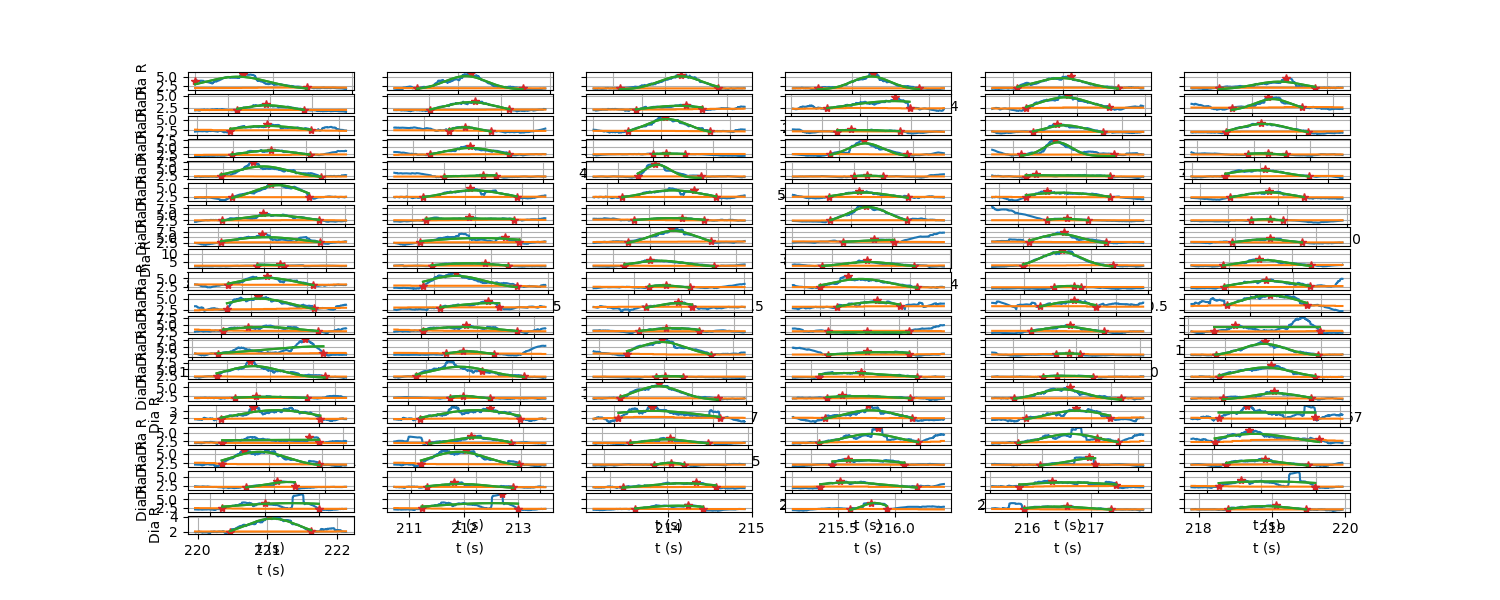

In [134]:
# Calculate the number of breaths in valid peaks
num_valid_breaths = len(valid_peaks_df)

print(f"The number of breaths in valid peaks is {num_valid_breaths}.")

mean_auc = valid_peaks_df['AUC'].mean()
print(f"The mean value of the attribute 'auc' for the valid breaths is {mean_auc}.")
# Calculate the median value of the attribute 'aub' for the valid breaths
median_auc = valid_peaks_df['AUC'].median()

print(f"The median value of the attribute 'auc' for the valid breaths is {median_auc}.")
# Calculate the standard deviation of the attribute 'aub' for the valid breaths
std_auc = valid_peaks_df['AUC'].std()

print(f"The standard deviation of the attribute 'auc' for the valid breaths is {std_auc}.")



The number of breaths in valid peaks is 121.
The mean value of the attribute 'auc' for the valid breaths is 3.045104783586633.
The median value of the attribute 'auc' for the valid breaths is 2.5481807795945577.
The standard deviation of the attribute 'auc' for the valid breaths is 1.7161673881919408.


In [135]:
# Detect local high baselines in EMGdi
emg_di_r.calculate_time_products(
    peak_set_name='breaths', parameter_name='AUB')
emg_di_r.test_emg_quality(
    peak_set_name='breaths', parameter_names=parameter_names, verbose=False)


emg_di_aubs = emg_di_r.peaks['breaths'].peak_df['AUB'].to_numpy()
valid_aubs = qa.detect_local_high_aub(
    aubs=emg_di_aubs,
    threshold_percentile=75,
    threshold_factor=4,
)
valid_aubs


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [136]:
ETPdi_r_list = emg_di_r.peaks['breaths'].peak_df['AUB'].to_numpy()
valid_etps = qa.detect_extreme_time_products(
    ETPdi_r_list,
    upper_percentile=95.0,
    upper_factor=10.0,
    lower_percentile=5.0,
    lower_factor=.1,
)
valid_etps


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [137]:
print(len(emg_di_r.peaks['breaths']))

349


In [ ]:
import matplotlib.pyplot as plt

# Define the breath number you want to plot
breath_number = 14  # Change this to the desired breath number

# Ensure the breath number is within the valid range
if breath_number < 1 or breath_number > len(emg_di_r.peaks['breaths'].quality_outcomes_df) - 2:
    raise ValueError("Breath number out of range. Please choose a number between 1 and {}.".format(len(emg_di_r.peaks['breaths'].quality_outcomes_df) - 2))

# Get the indices of the breaths to plot
start_idx = emg_di_r.peaks['breaths'].quality_outcomes_df.iloc[breath_number]['peak_idx']-2000
end_idx = emg_di_r.peaks['breaths'].quality_outcomes_df.iloc[breath_number + 4]['peak_idx']+500
# Extract the segments of the signals
filtered_segment = emg_di_r.y_clean[start_idx:end_idx]
envelope_segment = emg_di_r.y_env[start_idx:end_idx]
baseline_segment = emg_di_r.y_baseline[start_idx:end_idx]
time_segment = emg_di_r.t_data[start_idx:end_idx]

# Plot the segments
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(time_segment, filtered_segment, label='Filtered Data', linestyle='-')
ax.plot(time_segment, envelope_segment, label='Envelope', linestyle='-')
ax.plot(time_segment, baseline_segment, label='Baseline', linestyle='--')

# Add titles and labels
ax.set_title('Selected Breath and Surrounding Data')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude (uV)')
ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
quality_outcomes_df = emg_di_r.peaks['breaths'].quality_outcomes_df

# Count the number of False values in each specified column
columns_to_check = ['baseline_detection', 'interpeak_distance', 'snr', 'aub', 'bell']
false_counts = quality_outcomes_df[columns_to_check].apply(lambda col: (col == False).sum())

# Print the results
print(false_counts)